**• DOMAIN**: Social media analytics

**• CONTEXT**: Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in
these requires the availability of contextual tweets.In this hands-on project, the goal is to
build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

**• DATA DESCRIPTION**:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

Steps and tasks: [ Total Score: 30 points]
1. Read and explore the data
2. Retain relevant columns
3. Get length of each sentence
4. Define parameters
5. Get indices for words
6. Create features and labels
7. Get vocabulary size
8. Create a weight matrix using GloVe embeddings
9. Define and compile a Bidirectional LSTM model.
Hint: Be analytical and experimental here in trying new approaches to design the best model.
10. Fit the model and check the validation accuracy

## Importing Libraries

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import json
URL = '/gdrive/MyDrive/AIML/5. Sequential NLP/Project Sarcasm Detection News/Sarcasm_Headlines_Dataset.json'
with open(URL,'r') as f:
  data = [json.loads(line) for line in f]

In [4]:
data[:2]

[{'article_link': 'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205',
  'headline': 'thirtysomething scientists unveil doomsday clock of hair loss',
  'is_sarcastic': 1},
 {'article_link': 'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207',
  'headline': 'dem rep. totally nails why congress is falling short on gender, racial equality',
  'is_sarcastic': 0}]

In [5]:
# saving the data into a dataframe
data_df = pd.DataFrame(data)

In [6]:
data_df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Data Preprocessing

In [7]:
# dropping the article link column since headline data is enough for us
data_df.drop('article_link',axis=1,inplace=True)

In [8]:
data_df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [9]:
# determining length of each headline
data_df['headline_length'] = data_df['headline'].apply(lambda x:len(x.split()))

In [10]:
data_df

,is_sarcastic,headline,headline_length
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9
...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,7
28615,1,internal affairs investigator disappointed con...,13
28616,0,the most beautiful acceptance speech this week...,12
28617,1,mars probe destroyed by orbiting spielberg-gat...,8


In [11]:
# checking unique values in headline lengths
data_df['headline_length'].unique()

array([  8,  13,   7,   9,   3,  12,   6,  14,  10,  16,  11,   5,   4,
        18,  17,  15,  19,  20,  21,   2,  22,  23,  24,  29,  27,  25,
       151,  31,  26,  28,  38,  39,  30])

In [12]:
# checking stats of headline length
data_df['headline_length'].describe()

count    28619.000000
mean        10.049967
std          3.388307
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max        151.000000
Name: headline_length, dtype: float64

In [13]:
# checking for NaN values
data_df.isna().sum()

is_sarcastic       0
headline           0
headline_length    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


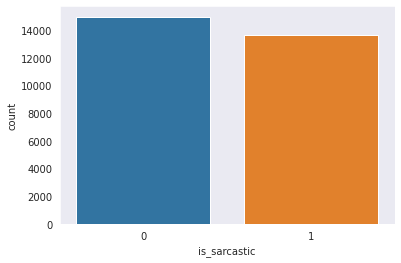

In [14]:
sns.set_style('dark')
sns.countplot(data_df.is_sarcastic)
# checking for class imbalance

In [15]:
print("Percent of non-sarcastic headlines: {}%".format(round(len(data_df[data_df.is_sarcastic==0])/len(data_df.is_sarcastic)*100),2))
print("Percent of sarcastic headlines: {}%".format(round(len(data_df[data_df.is_sarcastic==1])/len(data_df.is_sarcastic)*100),2))

Percent of non-sarcastic headlines: 52%
Percent of sarcastic headlines: 48%


There is a negligible class imbalance as seen above, so it shouldn't be so bad.

#### Defining Parameters

In [16]:
# defining parameters
max_features = 20000
max_len = 50
embedding_size = 100

#### Tokenization

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer(num_words = max_features)
# fitting tokenizer on text data
token.fit_on_texts(data_df['headline'])
# converting text to sequences
X = token.texts_to_sequences(data_df['headline'])

In [18]:
print("Number of samples: ",len(X))
print(X[0])

Number of samples:  28619
[16003, 354, 3166, 7473, 2643, 2, 660, 1118]


In [19]:
# getting indices of words
print(token.word_index)

{'to': 1, 'of': 2, 'the': 3, 'in': 4, 'for': 5, 'a': 6, 'on': 7, 'and': 8, 'with': 9, 'is': 10, 'new': 11, 'trump': 12, 'man': 13, 'at': 14, 'from': 15, 'about': 16, 'by': 17, 'after': 18, 'you': 19, 'this': 20, 'out': 21, 'up': 22, 'be': 23, 'as': 24, 'that': 25, 'it': 26, 'how': 27, 'not': 28, 'he': 29, 'his': 30, 'are': 31, 'your': 32, 'just': 33, 'what': 34, 'all': 35, 'who': 36, 'has': 37, 'will': 38, 'report': 39, 'into': 40, 'more': 41, 'one': 42, 'have': 43, 'year': 44, 'over': 45, 'why': 46, 'day': 47, 'u': 48, 'area': 49, 'woman': 50, 'can': 51, 's': 52, 'says': 53, 'donald': 54, 'time': 55, 'first': 56, 'like': 57, 'no': 58, 'her': 59, 'get': 60, 'off': 61, 'old': 62, "trump's": 63, 'life': 64, 'now': 65, 'people': 66, "'": 67, 'an': 68, 'house': 69, 'still': 70, 'obama': 71, 'white': 72, 'back': 73, 'make': 74, 'was': 75, 'than': 76, 'women': 77, 'if': 78, 'down': 79, 'when': 80, 'i': 81, 'my': 82, '5': 83, 'clinton': 84, 'could': 85, 'they': 86, 'their': 87, 'before': 88, 

#### Creating features and labels

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, maxlen=max_len)
y = np.asarray(data_df['is_sarcastic'])

In [21]:
print("Shape of features: ",X.shape)
print("Number of labels: ",len(y))

Shape of features:  (28619, 50)
Number of labels:  28619


In [22]:
# getting vocabulary size
num_words = len(token.word_index) + 1
#+1 for padding
print("Vocabulary size: ",num_words)

Vocabulary size:  30885


## GloVe Embeddings

In [23]:
# reading the glove embeddings from the file titled ‘glove.6B.100d.txt’
embedding_file = "/gdrive/MyDrive/AIML/5. Sequential NLP/Project Sarcasm Detection News/glove.6B.100d.txt"
# saving the embeddings to a dictionary having words and corresponding embedding vectors
embedding = {}

for o in open(embedding_file):
    word = o.split(" ")[0]
    embd = np.asarray(o.split(" ")[1:] , dtype = 'float32')
    embedding[word] = embd

In [24]:
len(embedding)

400000

In [25]:
# creating a weight matrix for words in the training docs
embedding_matrix = np.zeros((num_words,100))

for word,i in token.word_index.items():
  if word in embedding.keys():
    embedding_matrix[i] = embedding[word]

In [26]:
embedding_matrix.shape

(30885, 100)

## Encoding target variable

In [50]:
np.unique(y)

array([0, 1])

In [51]:
from tensorflow.keras.utils import to_categorical
y_en = to_categorical(y, num_classes=2)
y_en

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## Train-Test Split

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_en,test_size=0.3)

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20033, 50) (20033, 2)
(8586, 50) (8586, 2)


## Model building

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional

tf.keras.backend.clear_session()

model = Sequential()
# Embedding layer with input_dim, embedding_size, weights, input_length
model.add(Embedding(num_words, embedding_size, weights=[embedding_matrix], input_length=max_len))
## LSTM layers
model.add(Bidirectional(LSTM(128, return_sequences =True)))
model.add(Bidirectional(LSTM(64)))
## Extract Features
model.add(Flatten())
## Dense Layers
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           3088500   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

## Model Compile

In [56]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

## Model Fit

In [57]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=64)

Epoch 1/10
314/314 [==============================] - 29s 57ms/step - loss: 0.4491 - binary_accuracy: 0.7843 - val_loss: 0.3374 - val_binary_accuracy: 0.8506
Epoch 2/10
314/314 [==============================] - 16s 50ms/step - loss: 0.2579 - binary_accuracy: 0.8944 - val_loss: 0.3050 - val_binary_accuracy: 0.8742
Epoch 3/10
314/314 [==============================] - 16s 49ms/step - loss: 0.1535 - binary_accuracy: 0.9413 - val_loss: 0.3304 - val_binary_accuracy: 0.8707
Epoch 4/10
314/314 [==============================] - 16s 50ms/step - loss: 0.0808 - binary_accuracy: 0.9713 - val_loss: 0.4340 - val_binary_accuracy: 0.8658
Epoch 5/10
314/314 [==============================] - 16s 50ms/step - loss: 0.0416 - binary_accuracy: 0.9864 - val_loss: 0.5740 - val_binary_accuracy: 0.8623
Epoch 6/10
314/314 [==============================] - 16s 50ms/step - loss: 0.0286 - binary_accuracy: 0.9904 - val_loss: 0.6599 - val_binary_accuracy: 0.8573
Epoch 7/10
314/314 [==============================] 

## Training and validation accuracy and loss across epochs

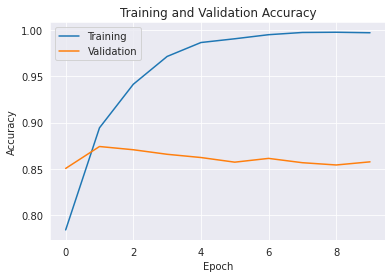

In [61]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='best')
plt.grid(True)

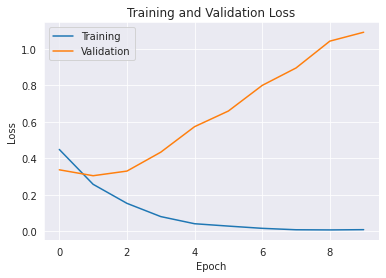

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='best')
plt.grid(True)

## Model Evaluation

In [66]:
# checking model's validation accuracy
print("Accuracy of the model on Testing Data is approximately - ",round(model.evaluate(X_test,y_test)[1]*100),"%")

269/269 [==============================] - 2s 8ms/step - loss: 1.0920 - binary_accuracy: 0.8577
Accuracy of the model on Testing Data is approximately -  86 %


## Confusion Matrix

In [67]:
y_pred = model.predict(X_test)
y_pred

array([[1.0000000e+00, 1.1361101e-13],
       [4.3273727e-14, 1.0000000e+00],
       [1.0000000e+00, 2.9443162e-10],
       ...,
       [1.0000000e+00, 1.9588069e-17],
       [1.0000000e+00, 2.6515303e-09],
       [1.0000000e+00, 1.1340226e-14]], dtype=float32)

In [68]:
y_test

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [69]:
# converting the predictons and actuals from OHE format to build a confuson matrix
Y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)
print(Y_pred)
print(Y_test)

[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [70]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(Y_test,Y_pred)
print(cm)
print(classification_report(Y_test,Y_pred))

[[3878  612]
 [ 610 3486]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4490
           1       0.85      0.85      0.85      4096

    accuracy                           0.86      8586
   macro avg       0.86      0.86      0.86      8586
weighted avg       0.86      0.86      0.86      8586



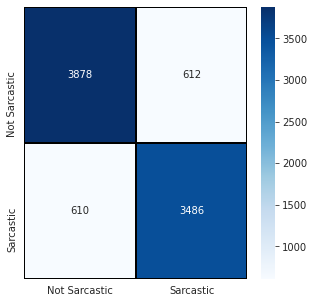

In [72]:
# visualising confusion matrix
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])